# Linear Classification 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import layers
from sixand7 import data_utils, layers

np.set_printoptions(precision=2)

## cifar-10 Data Loading and Preprocessing 

In [3]:
from data_utils import load_CIFAR10
cifar10_dir = '/Users/mahrokh/Desktop/cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_CIFAR10(cifar10_dir)
print('x_train: ',x_train.shape)
print('y_train = train label: ',y_train.shape)
print()
print('x_test: ',x_test.shape)
print('y_test = test label: ',y_test.shape)

x_train:  (50000, 32, 32, 3)
y_train = train label:  (50000,)

x_test:  (10000, 32, 32, 3)
y_test = test label:  (10000,)


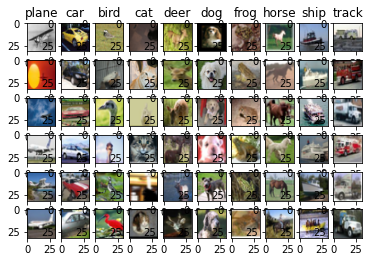

In [4]:
# visualize samples
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'track']
num_class = len(classes)
sample_per_class = 6
# print(list(enumerate(classes)))

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i*num_class + y + 1
        plt.subplot(sample_per_class, num_class, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        if i==0:
            plt.title(cls)
plt.show()

In [5]:
# Spilit data into train, val and test sets, development set(to make faster)
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# our validation data
mask = range(num_training, num_training + num_validation)
x_val = x_train[mask]
y_val = y_train[mask]

# our training data
mask = range(num_training)
x_train = x_train[mask]
y_train = y_train[mask]

# our development data
mask = np.random.choice(num_training, num_dev)
x_dev = x_train[mask]
y_dev = y_train[mask]

# our test data
mask = range(num_test)
x_test = x_test[mask]
y_test = y_test[mask]

print('train data: ',x_train.shape)
print('train labels: ',y_train.shape)
print('Validation data: ',x_val.shape)
print('Validation labels: ',y_val.shape)
print('test data: ',x_test.shape)
print('test labels: ',y_test.shape)


train data:  (49000, 32, 32, 3)
train labels:  (49000,)
Validation data:  (1000, 32, 32, 3)
Validation labels:  (1000,)
test data:  (1000, 32, 32, 3)
test labels:  (1000,)


## Preprocessing, reshape image data into rows

In [6]:
x_train = np.reshape(x_train,(x_train.shape[0], -1))
x_val = np.reshape(x_val, (x_val.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
x_dev = np.reshape(x_dev, (x_dev.shape[0],-1))
print('training shape 2d:', x_train.shape)
print('Validation data 2d:', x_val.shape)
print('test data 2d:', x_test.shape)
print('dev data 2d:', x_dev.shape)

training shape 2d: (49000, 3072)
Validation data 2d: (1000, 3072)
test data 2d: (1000, 3072)
dev data 2d: (500, 3072)


## Preprocessing, subtracting the mean

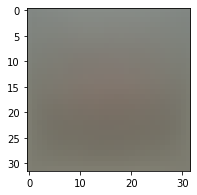

In [7]:
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(3,3))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'));

In [8]:
x_train -= mean_image
x_val -= mean_image
x_test -= mean_image
x_val -= mean_image

## Forward Step:

In [9]:
def affine_forward(w, x, b):
    x2d = np.reshape(x_train, (x_train.shape[0], -1))
    out = np.dot(x2d, w) + b
    cashe = (w, x, b)
    return out, cashe

## SVM:

#### vectorized implementation - svm

In [10]:
def L_i(x, y, w):
    scores = w.dot(x)
    correct_class_score = scores[y]
    c = w.shape[0] # number of classes
    
    loss_i = 0.0
    for j in range(c):
        if j==y:
            continue
        loss_i += max(0, scores[j] - correct_class_score + 1.0)
    return loss_i

In [11]:
def svm_loss_naive(scores, y, W, reg=1e-3):
    """
    Naive implementation of SVM loss function.

    Inputs:
        - scores: scores for all training data (N, C)
        - y: correct labels for the training data
        - reg: regularization strength (lambd)

    Outputs:
       - loss: data loss plus L2 regularization loss
       - grads: graidents of loss wrt scores
    """

    N, C = scores.shape

    # Compute svm data loss
    loss = 0.0
    for i in range(N):
        s = scores[i]  # scores for the ith data
        correct_class = y[i]  # correct class score

        for j in range(C):
            if j == y[i]:
                continue
            else:
                # loss += max(0, s[j] - s[correct_class] + 1.0)
                margin = s[j] - s[correct_class] + 1.0
                if margin > 0:
                    loss += margin
    loss /= N

    # Adding L2-regularization loss
    loss += 0.5 * reg * np.sum(W * W)

    # Compute gradient off loss function w.r.t. scores
    # We will write this part later
    grads = {} 

    return loss, grads

#### Half-vectorized - svm

In [12]:
def L_i(x, y, w):
    scores = w.dot(x)
    margins = np.maximum(0, scores - scores[y] + 1.0)
    margins[y] == 0
    loss_i = np.sum(margins)
    return loss_i

In [13]:
def svm_loss_half_vectorized(scores, y, W, reg=1e-3):
    """
    Half-vectorized implementation of SVM loss function.

    Inputs:
        - scores: scores for all training data (N, C)
        - y: correct labels for the training data
        - reg: regularization strength (lambd)

    Outputs:
       - loss: data loss plus L2 regularization loss
       - grads: graidents of loss wrt scores
    """

    N, C = scores.shape

    # Compute svm data loss
    loss = 0.0
    for i in range(N):
        s = scores[i]  # scores for the ith data
        correct_class = y[i]  # correct class score

        margins = np.maximum(0.0, s - s[correct_class] + 1.0)
        margins[correct_class] = 0.0
        loss += np.sum(margins)

    loss /= N

    # Adding L2-regularization loss
    loss += 0.5 * reg * np.sum(W * W)

    # Compute gradient off loss function w.r.t. scores
    # We will write this part later
    grads = {} 

    return loss, grads

#### Fully-vectorized

In [14]:
def svm_loss(scores, y, W, reg=1e-3):
    """
    Fully-vectorized implementation of SVM loss function.

    Inputs:
        - scores: scores for all training data (N, C)
        - y: correct labels for the training data
        - reg: regularization strength (lambd)

    Outputs:
       - loss: data loss plus L2 regularization loss
       - grads: graidents of loss wrt scores
    """

    N = scores.shape[0]

    # Compute svm data loss
    correct_class_scores = scores[range(N), y]
    margins = np.maximum(0.0, scores - correct_class_scores[:, None] + 1.0)
    margins[range(N), y] = 0.0
    loss = np.sum(margins) / N

    # Adding L2-regularization loss
    loss += 0.5 * reg * np.sum(W * W)

    # Compute gradient off loss function w.r.t. scores
    # We will write this part later
    grads = {} 

    return loss, grads

## create w and b randomly with small numbers

In [19]:
N = x_train.shape[0] # number of rows = data 
D = np.prod(x_train.shape[1:]) # number of column = features
c = 10



3072
